## Transform NRW motorway network to NRW region network

author: shanshan wang\
email: shanshan.wang@uni-due.de\
Feb. 29, 2024

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import osmnx as ox
import networkx as nx
import geopandas as gpd
import csv
import momepy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output


/Users/working/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/working/opt/anaconda3/lib/python3.8/site-packages/libpysal/examples/remotes.py:24: UserWarning: Remote data sets not available. Check connection.
  warnings.warn("Remote data sets not available. Check connection.")


### Load population density for NRW in 2021
data from  https://regionalatlas.statistikportal.de/#
Bevölkerungsdichte (EW je qkm)

In [2]:
popden=pd.read_csv('population_density_Germany_G-2021-AI002-1-5.csv',
                  sep=';',header=2)
popden_nrw=popden[(popden['schluessel']>=5000000) & (popden['schluessel']<6000000)]
popden_nrw.reset_index(drop=True, inplace=True)
popden_nrw.rename(columns={'regionaleinheit': 'name','wert':'pop_den'},inplace=True)
popden_nrw.drop(columns=['schluessel'],inplace=True)

/Users/working/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/Users/working/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
n2=['Langenfeld (Rheinland)','Sundern','Eslohe','Stolberg','Gronau','Leichlingen','Menden']
n1=['Langenfeld (Rhld.)','Sundern (Sauerland)','Eslohe (Sauerland)','Stolberg (Rhld.)','Gronau (Westf.)','Leichlingen (Rhld.)','Menden (Sauerland)']
popden_nrw.replace({n1[0]: n2[0], n1[1]: n2[1], n1[2]: n2[2], n1[3]: n2[3], 
                    n1[4]: n2[4], n1[5]: n2[5], n1[6]: n2[6]},inplace=True)


/Users/working/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [4]:
popden_nrw.shape

(396, 2)

### Check regions in NRW map

In [5]:
# boundary data from openstreetmap
nrw=gpd.read_file("boundary_North Rhine-Westphalia_multipolygons.geojson")

# add representative points for each region
#nrw['coords'] = nrw['geometry'].apply(lambda x: x.representative_point().coords[:])
nrw['coords'] = nrw['geometry'].apply(lambda x: x.centroid.coords[:])
nrw['coords'] = [coords[0] for coords in nrw['coords']]

nrw8=nrw[(nrw['admin_level']=='8')]
nrw8.reset_index(drop=True,inplace=True)
nrw6=nrw[(nrw['admin_level']=='6')]
nrw6.reset_index(drop=True,inplace=True)

In [6]:
# remove kreis before a name
for i in range(0,nrw6.shape[0]):
    if nrw6.name[i][0:6]=='Kreis ':
        nrw6.name[i]=nrw6.name[i][6:]
nrw6.name

<ipython-input-6-690995725961>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nrw6.name[i]=nrw6.name[i][6:]
/Users/working/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


0                          Wesel
1     Rheinisch-Bergischer Kreis
2                Minden-Lübbecke
3           Oberbergischer Kreis
4                      Gütersloh
5            Mülheim an der Ruhr
6                          Herne
7             Hochsauerlandkreis
8                Mönchengladbach
9                      Paderborn
10                          Unna
11                      Mettmann
12           Siegen-Wittgenstein
13                         Soest
14                     Steinfurt
15                    Leverkusen
16                         Düren
17                     Remscheid
18                      Duisburg
19                         Kleve
20                     Wuppertal
21                       Herford
22                         Lippe
23                       Viersen
24                          Hamm
25                          Bonn
26                 Gelsenkirchen
27                        Höxter
28             Rhein-Kreis Neuss
29                    Düsseldorf
30        

In [7]:
# test
nrw8_short=nrw8[['name','geometry']]
nrw6_short=nrw6[['name','geometry']]
nrw6_short['geometry'][0].covers(nrw6_short['geometry'][0])

True

In [8]:
# find the missing regions in nrw8
nrw8_short=nrw8[['name','geometry']]
nrw6_short=nrw6[['name','geometry']]
b=[]
idx=[]
for i in range(0,nrw6.shape[0]):
    a=[]
    for j in range(0,nrw8.shape[0]):
        a.append(nrw6_short['geometry'][i].covers(nrw8_short['geometry'][j]))
    try:
        # try to find true in the list a
        a.index(True)
    except ValueError:
        # if cannot find true in a, it means the i-th region in nrw6 does not cover any regions in nrw8
        b.append(i)    

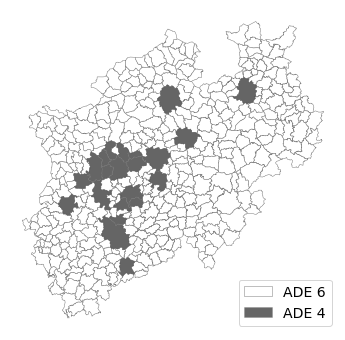

In [9]:
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Patch

# check if the indices in b are correct
fig, ax = plt.subplots(figsize = (6,6))
#nrw8.plot(ax=ax, color='darkblue', edgecolor='gray',zorder=1)
#nrw6.iloc[b].plot(ax=ax, color='darkorange', edgecolor='red',zorder=2,alpha=0.2)

nrw8.plot(ax=ax, color='white', edgecolor='gray',linewidth=0.5,zorder=1)
nrw6.iloc[b].plot(ax=ax, color='black', edgecolor='gray',linewidth=0.5,zorder=2,alpha=0.6)
ax.set_axis_off()
legend_elements = [Patch(edgecolor="gray",facecolor="white",linewidth=0.5,label='ADE 6'),
                   Patch(edgecolor="gray", facecolor="black",linewidth=0.5,alpha=0.6,label='ADE 4')]
plt.legend(handles=legend_elements, loc='lower right',fontsize=14)
plt.savefig('NRW_ADE4_ADE6.png',dpi=300)

In [10]:
# admin_level=6 -> ADE 4, admin_level=8 -> ADE 6
name_ADE4=nrw6.iloc[b].name.tolist()
df_name_ADE4 = pd.DataFrame(name_ADE4)
#df_name_ADE4.to_csv('region_name_ADE4.csv', index=False,header=False)

In [11]:
# combine the two regions
nrw68=pd.concat([nrw6.iloc[b],nrw8])
# reset index of nrw68
nrw68.reset_index(drop=True,inplace=True)
nrw68=nrw68[['name', 'geometry','coords']]
lon=[]
lat=[]
for i in range(0,nrw68.shape[0]):
    lon.append(nrw68.coords[i][0])
    lat.append(nrw68.coords[i][1])
nrw68['lon']=lon
nrw68['lat']=lat
    
nrw68.head()

,name,geometry,coords,lon,lat
0,Mülheim an der Ruhr,"MULTIPOLYGON (((6.81012 51.45555, 6.81028 51.4...","(6.8783210590979165, 51.413748100063145)",6.878321,51.413748
1,Herne,"MULTIPOLYGON (((7.17970 51.55269, 7.17878 51.5...","(7.208453824076478, 51.53750397862417)",7.208454,51.537504
2,Mönchengladbach,"MULTIPOLYGON (((6.53262 51.14596, 6.53074 51.1...","(6.412031159083005, 51.16730516827524)",6.412031,51.167305
3,Leverkusen,"MULTIPOLYGON (((7.09088 51.02581, 7.08998 51.0...","(7.0152463348943055, 51.05304307632232)",7.015246,51.053043
4,Remscheid,"MULTIPOLYGON (((7.22460 51.15807, 7.22443 51.1...","(7.223845647027924, 51.18268889912161)",7.223846,51.182689


In [12]:
# add population density to nrw68
# Kerkrade belongs to Netherlands
nrw68.drop(nrw68[nrw68.name=='Kerkrade'].index,inplace=True)
nrw68=pd.merge(nrw68, popden_nrw, how='left', on='name')
nrw68.head()

,name,geometry,coords,lon,lat,pop_den
0,Mülheim an der Ruhr,"MULTIPOLYGON (((6.81012 51.45555, 6.81028 51.4...","(6.8783210590979165, 51.413748100063145)",6.878321,51.413748,1870.5
1,Herne,"MULTIPOLYGON (((7.17970 51.55269, 7.17878 51.5...","(7.208453824076478, 51.53750397862417)",7.208454,51.537504,3045.9
2,Mönchengladbach,"MULTIPOLYGON (((6.53262 51.14596, 6.53074 51.1...","(6.412031159083005, 51.16730516827524)",6.412031,51.167305,1531.1
3,Leverkusen,"MULTIPOLYGON (((7.09088 51.02581, 7.08998 51.0...","(7.0152463348943055, 51.05304307632232)",7.015246,51.053043,2077.5
4,Remscheid,"MULTIPOLYGON (((7.22460 51.15807, 7.22443 51.1...","(7.223845647027924, 51.18268889912161)",7.223846,51.182689,1499.9


<Axes: >

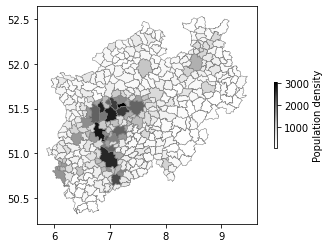

In [13]:
nrw68.plot(column='pop_den', edgecolor='gray',linewidth=0.5,cmap='Greys',legend=True,
         legend_kwds={'label': "Population density",'shrink': 0.3})

In [ ]:
nrw68.to_csv('nrw68.csv')
#nrw68.head()

In [14]:
nrw68.shape

(396, 6)

In [ ]:
# save boundary data nrw68 to shape file
import fiona
fiona.supported_drivers  
#nrw68[['name','pop_den','geometry']].to_file('nrw_admin_level8_boundary.shp')

In [15]:
nrw68.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Construct region network

In [16]:
# load motorway network
# data of motorway network from openstreetmap
mw=gpd.read_file("highway_motorway_North Rhine-Westphalia_lines.geojson")
mw_used=mw[['highway','ref','geometry']]
mw_used.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
# use `gpd.within()` to check whether a Point / Multi-Point or Line / Multi-Line lies within the selected area. 
city_list = list(nrw68['name'])
for i in range(0,len(city_list)):
    mw_used['city_'+city_list[i]] = mw_used['geometry'].within(nrw68['geometry'][i]).astype('int')
mw_used.head()

/Users/working/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,highway,ref,geometry,city_Mülheim an der Ruhr,city_Herne,city_Mönchengladbach,city_Leverkusen,city_Remscheid,city_Duisburg,city_Wuppertal,...,city_Schalksmühle,city_Herdecke,city_Borgentreich,city_Hilchenbach,city_Warburg,city_Bad Berleburg,city_Lennestadt,city_Gevelsberg,city_Hemer,city_Menden
0,motorway,A 3,"LINESTRING (7.32964 50.65067, 7.32992 50.65034...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,motorway,A 3,"LINESTRING (7.15881 50.89681, 7.16183 50.89599...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,motorway,,"LINESTRING (7.00726 51.04218, 7.00703 51.04263...",0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,motorway,A 57,"LINESTRING (6.89119 50.99679, 6.89379 50.99482...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,motorway,A 57,"LINESTRING (6.89063 50.99739, 6.88931 50.99840...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# define a function to get the name for a region
def get_city(row):
    for c in mw_used.iloc[:, 3:].columns:
        if row[c]==1:
            return c[5:]
mw_used['city'] = mw_used.iloc[:, 3:].apply(get_city, axis=1)

In [20]:
mw_used=mw_used[['highway','ref','geometry','city']]
mw_used

,highway,ref,geometry,city
0,motorway,A 3,"LINESTRING (7.32964 50.65067, 7.32992 50.65034...",Bad Honnef
1,motorway,A 3,"LINESTRING (7.15881 50.89681, 7.16183 50.89599...",Rösrath
2,motorway,,"LINESTRING (7.00726 51.04218, 7.00703 51.04263...",Leverkusen
3,motorway,A 57,"LINESTRING (6.89119 50.99679, 6.89379 50.99482...",Köln
4,motorway,A 57,"LINESTRING (6.89063 50.99739, 6.88931 50.99840...",Köln
...,...,...,...,...
13203,motorway,A 44,"LINESTRING (7.78430 51.52440, 7.78518 51.52441)",Unna
13204,motorway,A 44,"LINESTRING (7.78518 51.52441, 7.78779 51.52453)",Unna
13205,motorway,A 44,"LINESTRING (7.78521 51.52455, 7.78443 51.52453)",Unna
13206,motorway,A 1,"LINESTRING (7.66731 51.69591, 7.66755 51.69556)",Werne


In [21]:
ways=mw_used.ref.unique()
ways

array(['A 3', '', 'A 57', 'A 4', 'A 560', 'A 59', 'A 44', 'A 61', 'A 1',
       'A 2', 'A 45', 'A 43', 'A 31', 'A 52', 'A 40', 'A 1;A 61', 'A 42',
       'A 524', 'A 555', 'A 562', 'A 565', 'A 46', 'B 1', 'A 448', 'A 33',
       'A 30', 'A 553', 'B 514', 'A 542', 'A 535', 'A 516', 'E40', 'B 51',
       'A 544', 'A 445', 'A 3;A 4', 'L 84', 'A 559', 'L 124', 'A 40;A 40',
       'B 8', 'A67', 'A 43;B 474', 'A 57;A 46'], dtype=object)

In [22]:
# get city coordinates and population density
cityinfo=nrw68[['name','coords','pop_den','lon','lat']]
cityinfo.name.to_list()

['Mülheim an der Ruhr',
 'Herne',
 'Mönchengladbach',
 'Leverkusen',
 'Remscheid',
 'Duisburg',
 'Wuppertal',
 'Hamm',
 'Bonn',
 'Gelsenkirchen',
 'Düsseldorf',
 'Köln',
 'Münster',
 'Bottrop',
 'Bochum',
 'Bielefeld',
 'Solingen',
 'Essen',
 'Oberhausen',
 'Krefeld',
 'Hagen',
 'Dortmund',
 'Monheim am Rhein',
 'Hennef (Sieg)',
 'Wegberg',
 'Dinslaken',
 'Troisdorf',
 'Castrop-Rauxel',
 'Recklinghausen',
 'Velbert',
 'Heiligenhaus',
 'Ratingen',
 'Schermbeck',
 'Hamminkeln',
 'Wesel',
 'Xanten',
 'Sonsbeck',
 'Alpen',
 'Kamp-Lintfort',
 'Neukirchen-Vluyn',
 'Moers',
 'Hünxe',
 'Voerde (Niederrhein)',
 'Rheinberg',
 'Haltern am See',
 'Aachen',
 'Marl',
 'Oer-Erkenschwick',
 'Herten',
 'Gladbeck',
 'Dorsten',
 'Datteln',
 'Waltrop',
 'Wülfrath',
 'Mettmann',
 'Haan',
 'Erkrath',
 'Hilden',
 'Langenfeld (Rheinland)',
 'Erkelenz',
 'Langenberg',
 'Rheda-Wiedenbrück',
 'Rietberg',
 'Schwalmtal',
 'Viersen',
 'Willich',
 'Nettetal',
 'Kempen',
 'Tönisvorst',
 'Grefrath',
 'Brüggen',
 'Nied

In [23]:
#cityinfo.to_csv('cityinfo.csv', index=False)
len(cityinfo.name.to_list())

396

In [24]:
def swapindex(name1,name2,cw):
    idx1=cw[cw['name']==name1].index.to_list()[0]
    idx2=cw[cw['name']==name2].index.to_list()[0]
    b, c = cw.iloc[idx1].copy(), cw.iloc[idx2].copy()
    cw.iloc[idx1],cw.iloc[idx2] = c,b
    cw.reset_index(drop=True,inplace=True)
    return cw

def moveafter(name1,movename,cw):
    idx3=cw[cw['name']==movename].index.to_list()[0]
    cw3=cw.iloc[idx3:idx3+1].copy()
    cw.drop([idx3],inplace=True)
    cw.reset_index(drop=True,inplace=True)
    idx1=cw[cw['name']==name1].index.to_list()[0]
    
    cw1=cw.iloc[0:idx1+1,:].copy()
    cw2=cw.iloc[idx1+1:,:].copy()  
    cw4=pd.concat([cw1,cw3,cw2],axis=0) 
    cw4.reset_index(drop=True,inplace=True)
    return cw4

def movebefore(name2,movename,cw):
    idx3=cw[cw['name']==movename].index.to_list()[0]
    cw3=cw.iloc[idx3:idx3+1].copy()
    cw.drop([idx3],inplace=True)
    cw.reset_index(drop=True,inplace=True)
    idx2=cw[cw['name']==name2].index.to_list()[0]
    
    cw1=cw.iloc[0:idx2,:].copy()
    cw2=cw.iloc[idx2:,:].copy()  
    cw4=pd.concat([cw1,cw3,cw2],axis=0) 
    cw4.reset_index(drop=True,inplace=True)
    return cw4

def insertbetween(name1,name2,insertname,cw,cityinfo):
    idx3=cityinfo[cityinfo['name']==insertname].index.to_list()[0]
    idx1=cw[cw['name']==name1].index.to_list()[0]
    idx2=cw[cw['name']==name2].index.to_list()[0]
    cw3=cityinfo.iloc[idx3:idx3+1].copy()
    cw1=cw.iloc[0:idx1+1,:].copy()
    cw2=cw.iloc[idx2:,:].copy()  
    cw4=pd.concat([cw1,cw3,cw2],axis=0) 
    cw4.reset_index(drop=True, inplace=True)
    return cw4

def insertbefore(name2,insertname,cw,cityinfo):
    idx3=cityinfo[cityinfo['name']==insertname].index.to_list()[0]
    idx2=cw[cw['name']==name2].index.to_list()[0]
    cw3=cityinfo.iloc[idx3:idx3+1].copy()
    cw1=cw.iloc[0:idx2,:].copy()
    cw2=cw.iloc[idx2:,:].copy()  
    cw4=pd.concat([cw1,cw3,cw2],axis=0) 
    cw4.reset_index(drop=True, inplace=True)
    return cw4

def insertafter(name1,insertname,cw,cityinfo):
    idx3=cityinfo[cityinfo['name']==insertname].index.to_list()[0]
    idx1=cw[cw['name']==name1].index.to_list()[0]
    cw3=cityinfo.iloc[idx3:idx3+1].copy()
    cw1=cw.iloc[0:idx1+1,:].copy()
    cw2=cw.iloc[idx1+1:,:].copy()  
    cw4=pd.concat([cw1,cw3,cw2],axis=0) 
    cw4.reset_index(drop=True, inplace=True)
    return cw4

def dropcity(name,cw):
    cw.drop(cw[cw['name']==name].index,inplace=True)
    cw.reset_index(drop=True,inplace=True)
    return cw

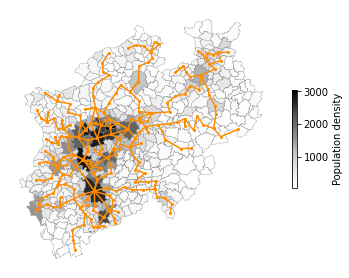

In [25]:
fig, ax = plt.subplots(figsize = (6,6))
city_connect=pd.DataFrame(data=0,index=cityinfo.name.to_list(),columns=cityinfo.name.to_list())
leg=[]
for way in ways:
    # if the name of a motorway contains '', ';', 'B', 'L', or 'E', ignore this motorway
    if way=='' or (';' in way)==1 or ('B' in way)==1 or ('L' in way)==1 or ('E' in way)==1:
        continue
    else:   
        # for each motorway, list the cities crossed over
        cross_cities=mw_used[(mw_used['ref']==way)&(mw_used['highway']=='motorway')].city.unique()

        city_way=pd.DataFrame()
        for i in range(0,len(cross_cities)):
            # for each city crossed over, get the city coordinates
            city_way=city_way.append(cityinfo[cityinfo.name==cross_cities[i]])

        # reset the index of the data frame of city_way
        city_way.reset_index(drop=True,inplace=True)
        
        
        if int(way[2:])%2==1:
            # if the motorway number is odd, sort cities by latitude
            city_way.sort_values(by=['lat'],ascending=True,inplace=True)   
        else:
            # if the motorway number is odd, sort cities by longitude
            city_way.sort_values(by=['lon'],ascending=True,inplace=True)  
       
        # reset the index of the data frame of city_way again
        city_way.reset_index(drop=True,inplace=True)
        
        # manually adjust the order of cities
        if way=='A 1':
            city_way=insertbetween('Erftstadt','Köln','Hürth',city_way,cityinfo)
            city_way=swapindex('Gevelsberg','Sprockhövel',city_way)
            city_way=swapindex('Hagen','Wetter (Ruhr)',city_way)
            city_way=dropcity('Leichlingen',city_way)
        if way=='A 3':
            city_way=insertbetween('Hamminkeln', 'Isselburg','Rees',city_way,cityinfo)
            city_way=insertbetween('Isselburg','Emmerich am Rhein','Rees',city_way,cityinfo)
        if way=='A 31':
            city_way=insertbetween('Gladbeck', 'Schermbeck','Bottrop',city_way,cityinfo)
            city_way=insertbefore('Schermbeck', 'Dorsten',city_way,cityinfo)
            city_way=insertbefore('Gescher', 'Velen',city_way,cityinfo)
        if way=='A 33':
            city_way=swapindex('Steinhagen','Bielefeld',city_way)
            city_way=swapindex('Versmold','Halle (Westf.)',city_way)
            city_way=insertbefore('Versmold','Borgholzhausen',city_way,cityinfo)
        if way=='A 43':
            city_way=swapindex('Senden','Nottuln',city_way)
        if way=='A 45':
            city_way=moveafter('Wenden','Olpe',city_way)
            city_way=swapindex('Gummersbach','Drolshagen',city_way)
        if way=='A 565':
            city_way=insertafter('Wachtberg', 'Meckenheim',city_way,cityinfo)
        if way=='A 57':
            city_way=insertafter('Krefeld', 'Moers',city_way,cityinfo)
            city_way=insertafter('Kamp-Lintfort', 'Rheinberg',city_way,cityinfo)
            city_way=insertafter('Rheinberg','Kamp-Lintfort', city_way,cityinfo)
            city_way=movebefore('Issum', 'Alpen',city_way)
            city_way=insertafter('Alpen','Kamp-Lintfort',city_way,cityinfo)
            city_way=swapindex('Kevelaer','Sonsbeck',city_way)
            city_way=insertafter('Kevelaer','Uedem',city_way,cityinfo)
            city_way=insertbefore('Weeze','Kevelaer',city_way,cityinfo)
        if way=='A 2':
            city_way=insertafter('Lünen','Kamen',city_way,cityinfo)
            city_way=swapindex('Beckum', 'Lippetal',city_way)
            city_way=swapindex('Herford','Bad Salzuflen',city_way)
            city_way=swapindex('Bad Oeynhausen', 'Vlotho',city_way)
        if way=='A 4':
            city_way=insertafter('Niederzier','Düren',city_way,cityinfo)
            city_way=insertbefore('Kerpen','Merzenich',city_way,cityinfo)
            city_way=insertafter('Kerpen','Frechen',city_way,cityinfo)
            city_way=insertafter('Olpe','Wenden',city_way,cityinfo)
        if way=='A 40':
            city_way=insertafter('Kempen','Kerken',city_way,cityinfo)
            city_way=insertbefore('Rheurdt','Kempen',city_way,cityinfo)
        if way=='A 44':
            city_way=moveafter('Titz','Bedburg',city_way)
            city_way=swapindex('Mönchengladbach','Jüchen',city_way)
            city_way=movebefore('Mönchengladbach','Korschenbroich',city_way)
            city_way=moveafter('Velbert','Essen',city_way)
            city_way=insertbefore('Werl','Unna',city_way,cityinfo)
            city_way=insertbefore('Anröchte','Erwitte',city_way,cityinfo)
        if way=='A 52':
            city_way=insertafter('Mönchengladbach','Viersen',city_way,cityinfo)
            city_way=insertafter('Viersen','Mönchengladbach',city_way,cityinfo)
            city_way=moveafter('Mülheim an der Ruhr','Essen',city_way)
            city_way=swapindex('Dorsten','Gelsenkirchen',city_way)
      
          
            
        # for each motorway, draw connections among cities
        # manually adjust the connections of cities
        lw=1.5
        ms=2
        if way=='A 59':
            city_way[0:4].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
            city_way[4:7].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
            city_way[7:].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3) 
        elif way=='A 61':
            city_way[0:8].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
            city_way[8:].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)    
        elif way=='A 30':
            city_way[0:6].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
            city_way[6:].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3) 
        elif way=='A 44':
            city_way[0:8].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
            city_way[8:14].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
            city_way[14:18].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
            city_way[18:21].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
            city_way[21:].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
        elif way=='A 46':
            city_way[0:12].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
            city_way[12:14].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
            city_way[14:].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
        elif way=='A 52':
            city_way[0:12].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
            city_way[12:].plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)
        else:  
            city_way.plot(x='lon', y='lat',kind='line', marker='o',color='darkorange',linewidth=lw, markersize=ms,legend=False, ax=ax, zorder=3)

        # add legend name
        leg.append(way)
         
        # assign city_connect by 1 if two cities are connected, and by 0 otherwise
        for i in range(0,city_way.shape[0]-1):
            city_connect.loc[city_way.name[i],city_way.name[i+1]]=1
            city_connect.loc[city_way.name[i+1],city_way.name[i]]=1
        if way=='A 59':
            city_connect.loc[city_way.name[3],city_way.name[4]]=0
            city_connect.loc[city_way.name[4],city_way.name[3]]=0
            city_connect.loc[city_way.name[6],city_way.name[7]]=0
            city_connect.loc[city_way.name[7],city_way.name[6]]=0
        if way=='A 61':
            city_connect.loc[city_way.name[7],city_way.name[8]]=0
            city_connect.loc[city_way.name[8],city_way.name[7]]=0
        if way=='A 30':
            city_connect.loc[city_way.name[5],city_way.name[6]]=0
            city_connect.loc[city_way.name[6],city_way.name[5]]=0
        if way=='A 44':
            city_connect.loc[city_way.name[7],city_way.name[8]]=0
            city_connect.loc[city_way.name[8],city_way.name[7]]=0
            city_connect.loc[city_way.name[13],city_way.name[14]]=0
            city_connect.loc[city_way.name[14],city_way.name[13]]=0
            city_connect.loc[city_way.name[17],city_way.name[18]]=0
            city_connect.loc[city_way.name[18],city_way.name[17]]=0
            city_connect.loc[city_way.name[20],city_way.name[21]]=0
            city_connect.loc[city_way.name[21],city_way.name[20]]=0
        if way=='A 46':
            city_connect.loc[city_way.name[11],city_way.name[12]]=0
            city_connect.loc[city_way.name[12],city_way.name[11]]=0
            city_connect.loc[city_way.name[13],city_way.name[14]]=0
            city_connect.loc[city_way.name[14],city_way.name[13]]=0
        if way=='A 52':
            city_connect.loc[city_way.name[11],city_way.name[12]]=0
            city_connect.loc[city_way.name[12],city_way.name[11]]=0
            


# draw boundaries of cities  ,legend=True
nrw68.plot(column='pop_den', edgecolor='gray',linewidth=0.3, zorder=1, ax=ax, cmap='Greys',legend=True,
         legend_kwds={'label': "Population density",'shrink': 0.3})

# add city names
#for idx, row in nrw.iterrows():
#    plt.annotate(text=row['GEN'], xy=row['coords'], horizontalalignment='center', color='black',size=8, zorder=2)
ax.set_axis_off()
#plt.savefig('region_network.png',dpi=300)



In [ ]:
city_connect.to_csv('region_connect.csv', index=False,header=False)

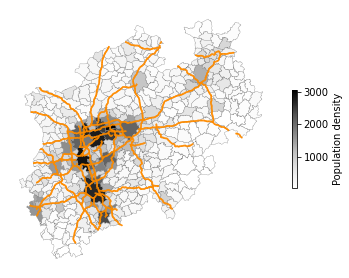

In [27]:
# compare the above map with the real motorway network
fig, ax = plt.subplots(figsize = (6,6))
nrw68.plot(column='pop_den', edgecolor='gray', linewidth=0.3, zorder=1, ax=ax, cmap='Greys',legend=True,
         legend_kwds={'label': "Population density",'shrink': 0.3})
mw_used.plot(color='darkorange',linewidth=1.5, ax=ax, zorder=2)
#for idx, row in nrw68.iterrows():
#    plt.annotate(text=row['name'], xy=row['coords'], horizontalalignment='center', color='black',size=8, zorder=3)
ax.set_axis_off()
#plt.savefig('motorway_network.png',dpi=300)

### Find neighbouring regions/cities

In [28]:
city_neighbour=pd.DataFrame(data=0,index=nrw68.name.to_list(),columns=nrw68.name.to_list())
for index, row in nrw68.iterrows():  
    neighbours = nrw68[nrw68.geometry.touches(row['geometry'])].name.to_list() 
    if row['name']=='Hürth':
        neighbours=['Frechen','Köln','Brühl','Erftstadt','Kerpen']
    if row['name']=='Frechen':
        neighbours=['Hürth','Kerpen','Bergheim','Pulheim','Köln']
    if row['name']=='Roetgen':
        neighbours=['Aachen','Stolberg','Simmerath']       
    nrw68.at[index, "my_neighbours"] = ", ".join(neighbours)
    city_neighbour.loc[neighbours,row['name']]=1
    city_neighbour.loc[row['name'],neighbours]=1

    

In [29]:
nrw68[nrw68['name']=='Roetgen']

,name,geometry,coords,lon,lat,pop_den,my_neighbours
221,Roetgen,"MULTIPOLYGON (((6.18353 50.64697, 6.18346 50.6...","(6.228012065420689, 50.68173675149762)",6.228012,50.681737,221.8,"Aachen, Stolberg, Simmerath"


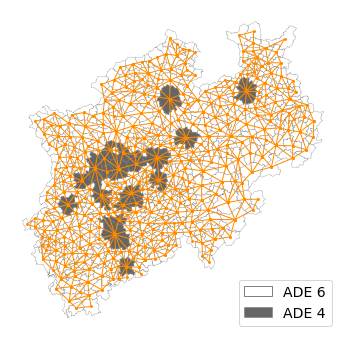

In [30]:
fig, ax = plt.subplots(figsize = (6,6))
# connect neighbouring cities in map
for ind1, row1 in cityinfo.iterrows():
    for ind2, row2 in cityinfo.iterrows():
        if city_neighbour.loc[row1['name'],row2['name']]==1 and ind1<=ind2:
            plt.plot([row1['lon'],row2['lon']], [row1['lat'],row2['lat']],'o-',color='darkorange',
                      linewidth=1, markersize=1.5, zorder=3)
# draw boundaries of cities  ,legend=True
#nrw68.plot(column='pop_den', edgecolor='gray',linewidth=0.5, zorder=1, ax=ax, cmap='Greys',legend=False,
#         legend_kwds={'label': "Population density",'shrink': 0.3})

nrw8.plot(ax=ax, color='white', edgecolor='gray',linewidth=0.3,zorder=1)
nrw6.iloc[b].plot(ax=ax, color='black', edgecolor='gray',linewidth=1,zorder=2,alpha=0.6)
ax.set_axis_off()
legend_elements = [Patch(edgecolor="gray",facecolor="white",linewidth=1,label='ADE 6'),
                   Patch(edgecolor="gray", facecolor="black",linewidth=1,alpha=0.6,label='ADE 4')]
plt.legend(handles=legend_elements, loc='lower right',fontsize=14)
#plt.savefig('neighbour_connect.png',dpi=300)

In [ ]:
city_neighbour.to_csv('region_neighbour.csv', index=False,header=False)